<a href="https://colab.research.google.com/github/ameyvadnere/CS418-Statistical-Pattern-Recognition-Lab/blob/master/Assn1_Q1a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# Import necessary libraries

from keras.datasets import mnist  # MNIST Dataset
import numpy as np                # For numerical computations
from tqdm.notebook import tqdm    # For progress bar
import seaborn as sns             # Plotting
from scipy.stats import multivariate_normal     # Multivariate Gaussian function
from scipy.stats import norm
import matplotlib.pyplot as plt     # Plotting

In [30]:
m_train, m_test = 60000, 10000  # Training and testing size
n = 784     # Dimensionality

(train_X, train_y), (test_X, test_y) = mnist.load_data()        # Loading the dataset into numpy array

train_X = train_X.reshape(-1, n)/255.
test_X = test_X.reshape(-1, n)/255.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


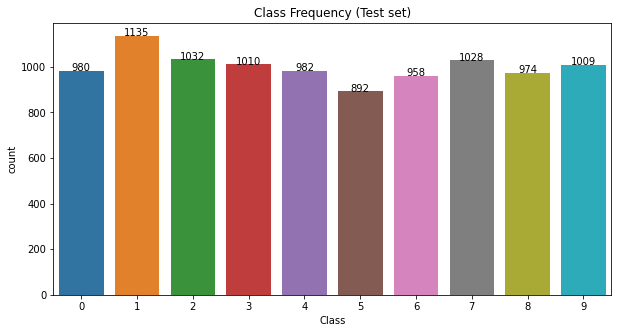

In [31]:
plt.figure(figsize=(10,5))
ax = sns.countplot(test_y)
ax.set_title('Class Frequency (Test set)')
ax.set_xlabel('Class')

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1, np.sum(test_y == i),ha="center")

In [32]:
# This function estimates the necessary parameters to define the pdf

def compute_covs_means(train_X, train_y, classes=list(range(10))):
    means = []      # Sample means
    covs = []       # Sample covariance matrices
    cov_invs = []   # Inverses of sample covariance matrices
    cov_dets = []   # Determinants of covariance matrices
    k = train_X.shape[1]

    for i in tqdm(range(len(classes))):
        filter = np.where(train_y == classes[i])
        X = train_X[filter]

        mean_array = np.mean(X, axis=0)
        cov_matrix = np.cov(X, rowvar=False, ddof=True) + 0.5 * np.eye(k)  # Adding noise to make det(cov_matrix) non zero. ddof=True returns unbiased estimate.
        det_cov = np.linalg.det(cov_matrix)
        cov_inv = np.linalg.inv(cov_matrix)

        means.append(mean_array)
        covs.append(cov_matrix)
        cov_invs.append(cov_inv)
        cov_dets.append(det_cov)
        

    return means, covs, cov_invs, cov_dets

# Compute prior probabilities
def compute_priors(train_X, train_y, classes=list(range(10))):
    priors = {}     # Prior probabilities
    for i in classes:
        filter = np.where(train_y == i)
        X = train_X[filter]
        count = X.shape[0]
        # priors.append(count/train_X.shape[0])
        priors[i] = count/train_X.shape[0]

    return priors

# Plot distribution of features
def plot_distributions(train_X, train_y):
    fig, axes = plt.subplots(10, 3, figsize=(9, 30))
    for i in range(10):
        x = train_X[train_y == i]
        feats = [42, 392, 489]
        for j in range(3):
            axes[i,j].hist(x[feats[j]], density=True)
            axes[9,j].set_xlabel('Feature ' + str(feats[j]))    
        axes[i,0].set_ylabel('Class ' + str(i))

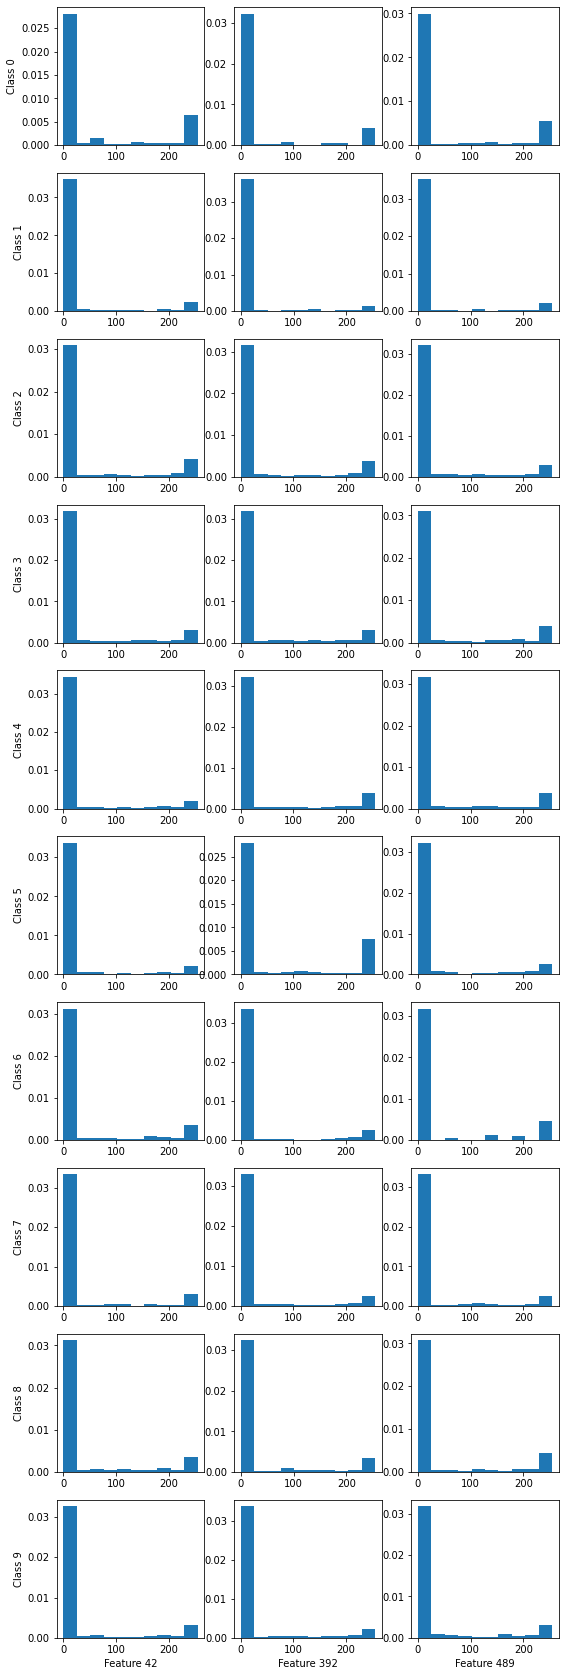

In [28]:
plot_distributions(train_X, train_y)

In [33]:
means, covs, cov_invs, cov_dets = compute_covs_means(train_X, train_y)
priors = compute_priors(train_X, train_y)

for i in range(10):
    print(covs[i].min(), covs[i].max(), cov_dets[i])


-0.1203365661591198 0.6965833614188854 5.684902792340671e-216
-0.13371108006277452 0.7012275796377854 2.161280490247663e-227
-0.11257119984056298 0.6990499355322892 1.308711788542581e-212
-0.11593709688378079 0.6928158802968167 4.754030578892308e-215
-0.1117850290817117 0.6933063279639978 6.6669614599258524e-217
-0.10348910532922505 0.6932865552333664 9.116153393821632e-215
-0.10993463258073453 0.6918494078140798 2.585479738919893e-217
-0.11283245358780834 0.6938391033671761 2.8567857725125645e-219
-0.08791425387241933 0.6888896014908109 4.661240944678429e-214
-0.11083755167989517 0.6919432809008829 1.2614411023251833e-218


In [34]:
# Visualize how the mean images look like.
def show_means(means):
    fig = plt.figure(figsize=(12,12))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    for i in range(len(means)):
        
        ax = fig.add_subplot(4, 3, i+1, xticks=[], yticks=[])
        ax.imshow(means[i].reshape(28,28), cmap='gray')
    
    plt.show()


# Visualize the covariance matrices
def show_covs(covs):
    fig = plt.figure(figsize=(12,12))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i in range(len(covs)):
        
        ax = fig.add_subplot(4, 3, i+1, xticks=[], yticks=[])
        ax.imshow(covs[i])
        plt.title("Class " + str(i))
        
    
    plt.show()

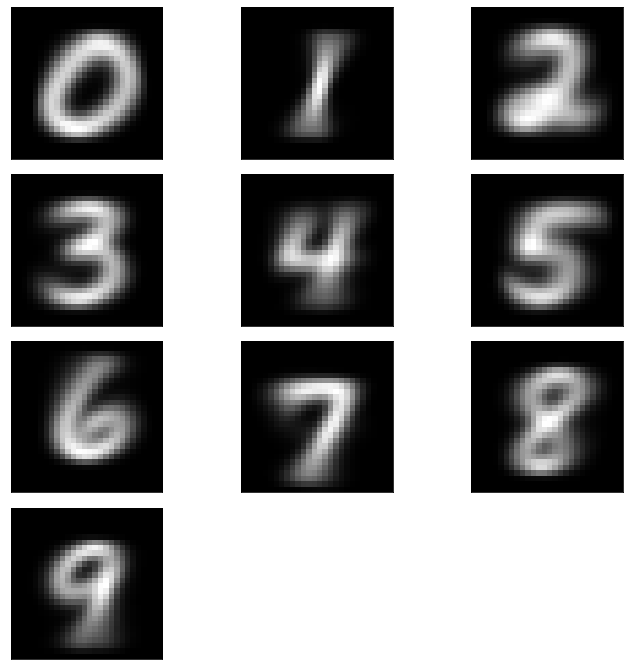

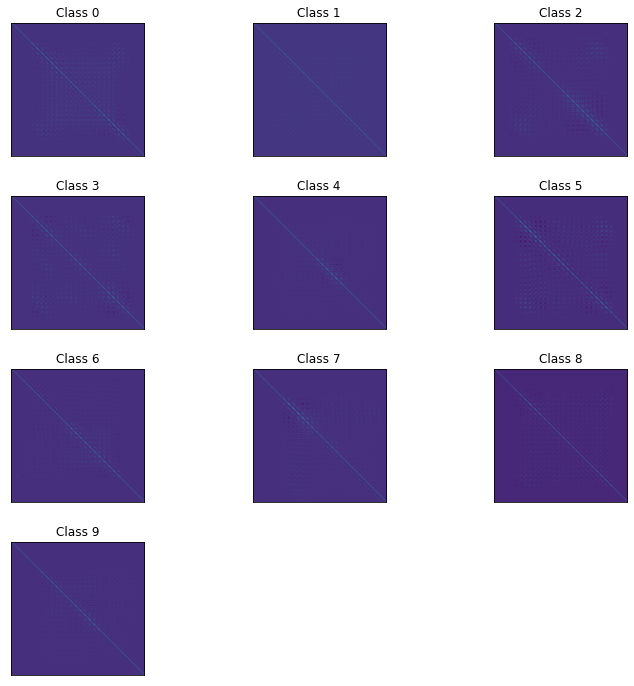

In [35]:
show_means(means)
show_covs(covs)

In [36]:
# Returns a value directly proportional to the posterior probability
def posterior(X, i, priors): 
    mean, cov, cov_inv, cov_det, prior = means[i], covs[i], cov_invs[i], cov_dets[i], priors[i]
    z = X - mean.T
    w = z @ cov_inv
    numerator = np.exp(-0.5 * (w * z).sum(axis=1))
    denominator = np.sqrt(cov_det)

    return numerator/denominator * prior

In [37]:
# Predict a class for each sample in X matrix
def predict(X, classes=list(range(10))):
    posteriors = []
    priors = compute_priors(train_X, train_y, classes)
    for i in classes:
        probs = posterior(X, i, priors)
        posteriors.append(probs)
    
    print("Posterior shape ", np.array(posteriors).shape)
    return np.array([classes[x] for x in np.argmax(posteriors, axis=0)])


In [38]:
# Predictions for an image

preds_train = predict(train_X)
preds = predict(test_X)

Posterior shape  (10, 60000)
Posterior shape  (10, 10000)


In [39]:
# Train and Test Accuracy
print("Train Accuracy: ", np.mean(preds_train == train_y))
print("Test Accuracy: ", np.mean(preds == test_y))

Train Accuracy:  0.91585
Test Accuracy:  0.92


Text(0.5, 1.0, 'Confusion Matrix (10 classes)')

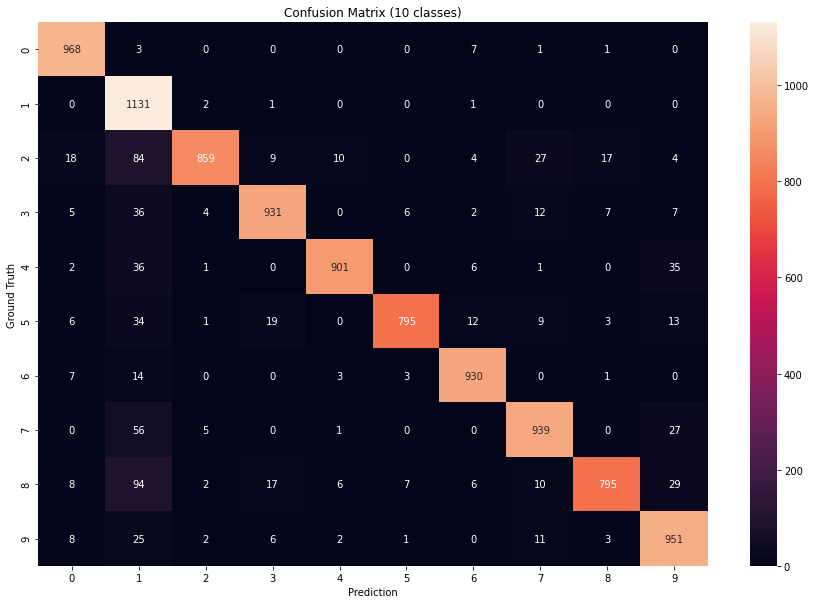

In [41]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_y, preds)
plt.figure(figsize=(15,10))
sns.heatmap(cm, annot=True, fmt='.0f')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix (10 classes)')

Posterior shape  (3, 18831)
Posterior shape  (3, 3177)
Train Accuracy:  0.9473740109394084
Test Accuracy:  0.9490084985835694


Text(69.0, 0.5, 'Ground Truth')

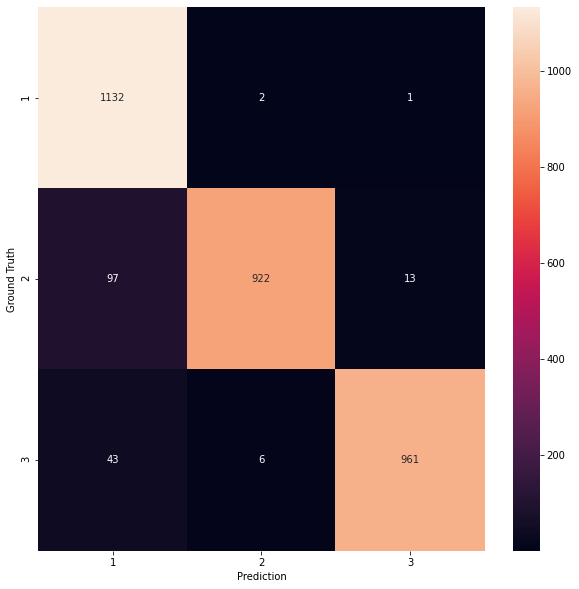

In [59]:
# Generating different subsets: Classes = [1,2,3]

subset1 = np.where((train_y == 1) | (train_y == 2) | (train_y == 3))
subset2 = np.where((test_y == 1) | (test_y == 2) | (test_y == 3))
preds_train = predict(train_X[subset1], [1, 2, 3])
preds = predict(test_X[subset2], [1, 2, 3])

# Train Accuracy:
print("Train Accuracy: ", np.mean(preds_train == train_y[subset1]))
# Test Accuracy
print("Test Accuracy: ", np.mean(preds == test_y[subset2]))

# Confusion matrix

cm = confusion_matrix(test_y[subset2], preds)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='.0f', xticklabels=[1,2,3], yticklabels=[1,2,3])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')

Posterior shape  (3, 18956)
Posterior shape  (3, 3172)
Train Accuracy:  0.9639691918126186
Test Accuracy:  0.9618537200504413


Text(69.0, 0.5, 'Ground Truth')

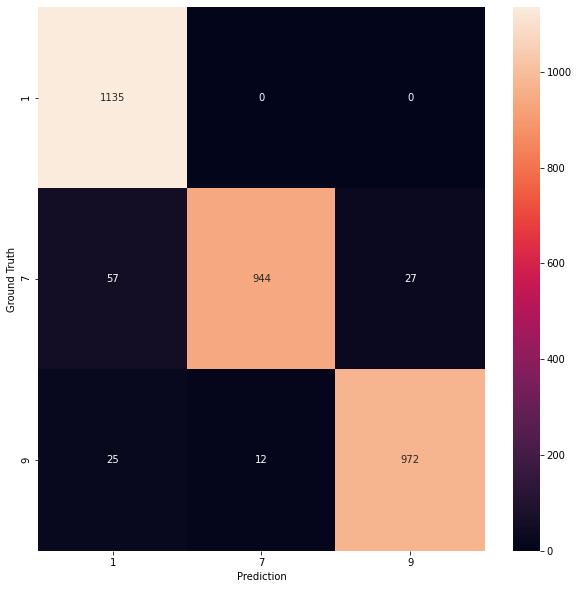

In [51]:
# Generating different subsets: Classes = [1,7,9]

subset1 = np.where((train_y == 1) | (train_y == 7) | (train_y == 9))
subset2 = np.where((test_y == 1) | (test_y == 7) | (test_y == 9))
preds_train = predict(train_X[subset1], [1, 7, 9])
preds = predict(test_X[subset2], [1, 7, 9])


# Train Accuracy
print("Train Accuracy: ", np.mean(preds_train == train_y[subset1]))
# Test Accuracy
print("Test Accuracy: ", np.mean(preds == test_y[subset2]))

# Confusion matrix

cm = confusion_matrix(test_y[subset2], preds)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='.0f', xticklabels=[1,7,9], yticklabels=[1,7,9])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')

Posterior shape  (3, 17905)
Posterior shape  (3, 2964)
Train Accuracy:  0.979056129572745
Test Accuracy:  0.9821187584345479


Text(69.0, 0.5, 'Ground Truth')

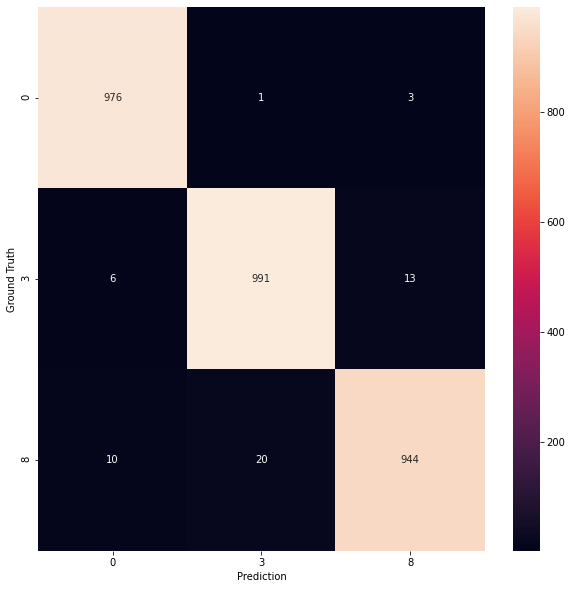

In [52]:
# Generating different subsets: Classes = [0, 3, 8]

subset1 = np.where((train_y == 0) | (train_y == 3) | (train_y == 8))
subset2 = np.where((test_y == 0) | (test_y == 3) | (test_y == 8))
preds_train = predict(train_X[subset1], [0,3,8])
preds = predict(test_X[subset2], [0, 3, 8])

# Train Accuracy
print("Train Accuracy: ", np.mean(preds_train == train_y[subset1]))
# Test Accuracy
print("Test Accuracy: ", np.mean(preds == test_y[subset2]))

# Confusion matrix

cm = confusion_matrix(test_y[subset2], preds)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='.0f', xticklabels=[0,3,8], yticklabels=[0,3,8])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')

Posterior shape  (3, 17922)
Posterior shape  (3, 3001)
Train Accuracy:  0.9667447829483317
Test Accuracy:  0.9723425524825058


Text(69.0, 0.5, 'Ground Truth')

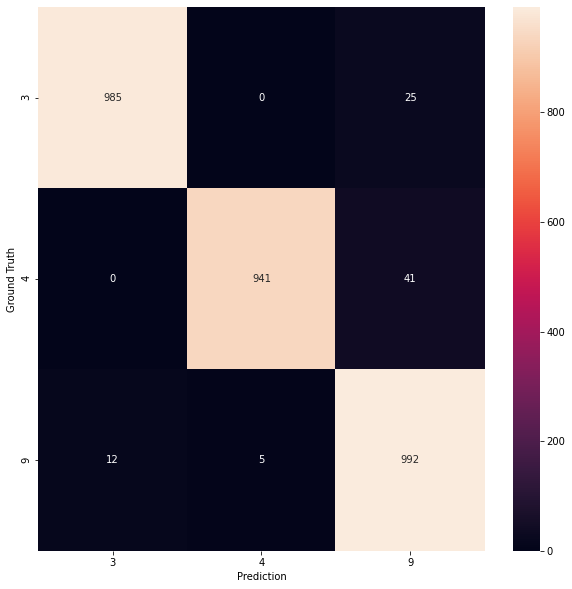

In [54]:
# Generating different subsets: Classes = [3,4,9]

subset1 = np.where((train_y == 3) | (train_y == 4) | (train_y == 9))
subset2 = np.where((test_y == 3) | (test_y == 4) | (test_y == 9))
preds_train = predict(train_X[subset1], [3, 4, 9])
preds = predict(test_X[subset2], [3, 4, 9])

# Train Accuracy
print("Train Accuracy: ", np.mean(preds_train == train_y[subset1]))
# Test Accuracy
print("Test Accuracy: ", np.mean(preds == test_y[subset2]))

# Confusion matrix

cm = confusion_matrix(test_y[subset2], preds)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='.0f', xticklabels=[3,4,9], yticklabels=[3,4,9])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')

Posterior shape  (4, 24816)
Posterior shape  (4, 4169)
Train Accuracy:  0.9193665377176016
Test Accuracy:  0.9232429839289997


Text(69.0, 0.5, 'Ground Truth')

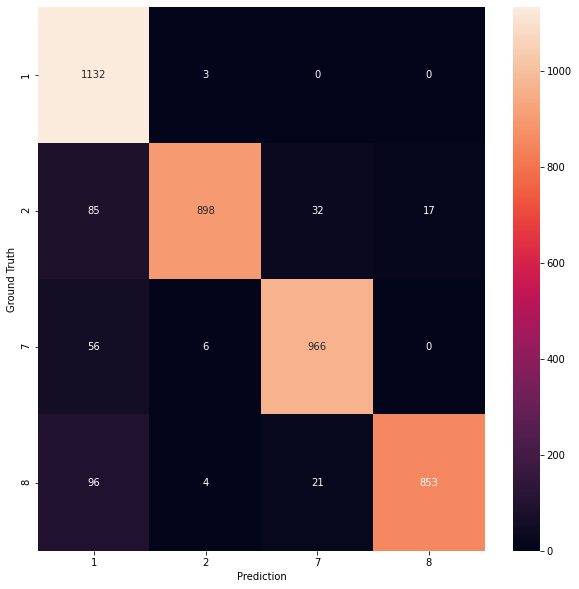

In [43]:
# Generating different subsets: Classes = [1,2,7,8]

subset1 = np.where((train_y == 1) | (train_y == 2) |(train_y == 7) | (train_y == 8))
subset2 = np.where((test_y == 1) | (test_y == 2) | (test_y == 7) |(test_y == 8))
preds_train = predict(train_X[subset1], [1,2,7,8])
preds = predict(test_X[subset2], [1,2,7,8])

# Train Accuracy
print("Train Accuracy: ", np.mean(preds_train == train_y[subset1]))
# Test Accuracy
print("Test Accuracy: ", np.mean(preds == test_y[subset2]))

# Confusion matrix

cm = confusion_matrix(test_y[subset2], preds)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='.0f', xticklabels=[1,2,7,8], yticklabels=[1,2,7,8])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')